In [63]:
!pip install openpyxl
!pip install awswrangler
import openpyxl
import awswrangler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import boto3
import io
import os
# s3_path = "s3://<your-bucket-name>/food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx"
s3_path = "s3://c93435a2086654l4910637t1w0854223549-sandboxbucket-yk2arc2gss8l/food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx"
df = awswrangler.s3.read_excel(s3_path, sheet_name="CropStats", usecols=lambda name: name != 'Unnamed: 0')
print(df.head())

   Harvest_year   admin0 admin1   crop  hectares (ha)  production (tonnes)  \
0          1902  Austria    NaN  wheat            NaN                  NaN   
1          1903  Austria    NaN  wheat            NaN                  NaN   
2          1904  Austria    NaN  wheat            NaN                  NaN   
3          1905  Austria    NaN  wheat            NaN                  NaN   
4          1906  Austria    NaN  wheat            NaN                  NaN   

   year  yield(tonnes/ha)  admin2 notes  
0  1902              1.31     NaN   NaN  
1  1903              1.47     NaN   NaN  
2  1904              1.27     NaN   NaN  
3  1905              1.33     NaN   NaN  
4  1906              1.28     NaN   NaN  


In [64]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)
# Filter for wheat
df = df[df['crop'] == 'wheat']
# Remove the crop column
df.drop('crop', axis=1, inplace =True)
# Logarithmic transformations
df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
df['log_hectares'] = np.log1p(df['production_tonnes'])
df['log_production'] = np.log1p(df['hectares_ha'])
print(df.head())

   national subnational  hectares_ha  production_tonnes  year  \
59  Austria     Austria     275822.0         711620.760  1961   
60  Austria     Austria     270351.0         706156.812  1962   
61  Austria     Austria     274722.0         689552.220  1963   
62  Austria     Austria     282967.0         750428.484  1964   
63  Austria     Austria     275654.0         660742.638  1965   

    yield_tonnes_ha  log_yield  log_hectares  log_production  
59            2.580   1.275363     13.475302       12.527515  
60            2.612   1.284262     13.467594       12.507480  
61            2.510   1.255616     13.443799       12.523519  
62            2.652   1.295275     13.528401       12.553089  
63            2.397   1.222893     13.401121       12.526905  


<Axes: >

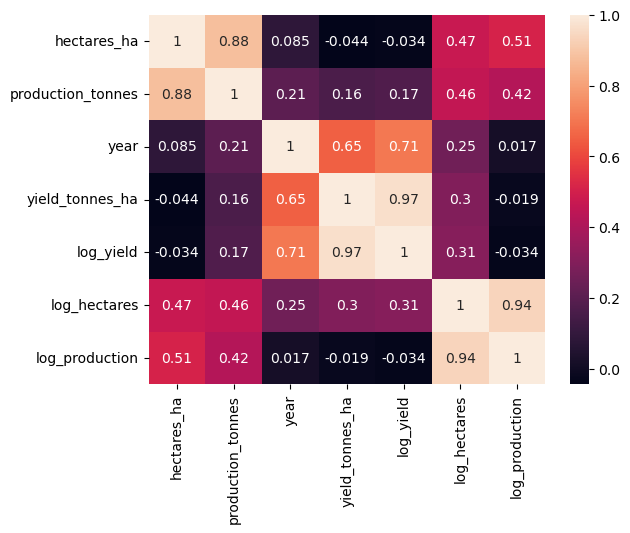

In [65]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

In [66]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(df, 
                                            test_size=0.2, 
                                            random_state=42)
#                                             stratify=df_wine['quality'])
test, validate = train_test_split(test_and_validate, 
                                  test_size=0.5, 
                                  random_state=42)
#                                   stratify=test_and_validate['quality'])
print(train.shape)
print(test.shape)
print(validate.shape)

(12383, 9)
(1548, 9)
(1548, 9)


In [67]:
# bucket='c93435a2086654l4910637t1w0854223549-sandboxbucket-jtqmwpnickrd'
bucket='c93435a2086654l4910637t1w0854223549-sandboxbucket-yk2arc2gss8l'
prefix='CropDataModelHannah'
train_file='crop_train.csv'
test_file='crop_test.csv'
validate_file='crop_validate.csv'
whole_file='crop.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [68]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
lr = LinearRegression()

# Fit the model to the training data
lr.fit(train[['log_hectares', 'log_production']], train['log_yield'])

# Make predictions on the test data
test_predictions = lr.predict(test[['log_hectares', 'log_production']])

# Calculate the mean squared error (MSE) on the test data
mse = np.mean((test_predictions - test['log_yield'])**2)

# Print the MSE
print('MSE:', mse)

# Calculate the accuracy of the predictions
accuracy = np.mean(test_predictions == test['log_yield'])

# Print the accuracy
print('Accuracy:', accuracy)

MSE: 0.006179489793294084
Accuracy: 0.0


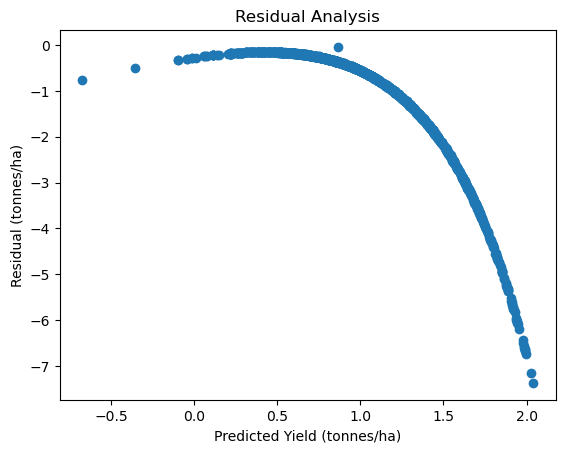

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot
plt.scatter(test_predictions, test_predictions - test['yield_tonnes_ha'])

# Add a title and axis labels
plt.title('Residual Analysis')
plt.xlabel('Predicted Yield (tonnes/ha)')
plt.ylabel('Residual (tonnes/ha)')

# Show the plot
plt.show()

In [70]:
import boto3

s3 = boto3.client('s3')

In [71]:
import botocore

s3_client = boto3.client('s3')

try:
    s3_client.get_bucket_acl(Bucket=bucket)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDenied':
        print('The s3 variable does not have permission to access the S3 bucket.')
        exit(1)

In [72]:
import pickle

# Save the trained model to S3
with open('model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Upload the trained model to S3
s3.upload_file('model.pkl', bucket, os.path.join(prefix, 'model', 'model.pkl'))